# Result Visualization

In this notebook, we visualize the results from the experiments we ran. In order to use this notebook, you must have run the script found under `deeptutor/scripts/run.py`, which should have generated a variety of pickle files in a directory named `data`.

## Imports

First, we import the necessasry variables and define useful global variables. Feel free to edit these global variables if you have your data stored in a different location or if you only ran a subset of the experiments.

In [1]:
import pickle
import numpy as np
from matplotlib import pyplot as plt
import os

data_dir = "data"
reward_funcs = ["likelihood", "log_likelihood"]
envs = ["EFC", "HLR", "DASH"] 
tutor_builders = [
    "Random",
    "Leitner",
    "SuperMnemo",
    "Threshold",
    "DQN",
#     "PPO",
    "MLPTRPO",
    "GRUTRPO"
]
rl_tutors = ["DQN", "PPO", "MLPTRPO", "GRUTRPO"]

## Data Aggregation

In this next cell, we aggregate the data from all the experiments into a global data tensor in order to process the data more effciently. We create the $R$ tensor which has shape (# of environments * # of reward functions, # of tutors, # of items, # of seeds).

In [2]:
R = np.empty((6,0,100,10))
for tutor in tutor_builders:
    with open(os.path.join(data_dir, f"{tutor}_reward_logs.pkl"), "rb") as f:
        rewards = pickle.load(f)["rewards"]
    temp = np.empty((0, 100, 10))
    for env_name in envs:
        for reward_func in reward_funcs:
            env = (
                env_name + "-" + ("L" if reward_func == "likelihood" else "LL")
            )
            if env in rewards:
                temp = np.append(temp, (np.expand_dims(rewards[env], axis=0)), axis=0)
    R = np.append(R, (np.expand_dims(temp, axis=1)), axis=1)

## Standardize Data

Next, we want standard all of our data by substracting our the results from our RandomTutor from each experiment in order to set our RandomTutor as a baseline for all of our experiments. This allows us to more effectively compare results. We also define a few helper functions to normalize our data in terms of the mean and standard deviation.

In [3]:
for i in range(R.shape[0]):
    for j in range(R.shape[3]):
        R[i, :, :, j] = 100 * (R[i, :, :, j] - R[i, 0, :, j]) / abs(R[i, 0, :, j])

In [4]:
r_means = lambda x: np.nanmean(x, axis=1)
r_stderrs = lambda x: np.nanstd(x, axis=1) / np.sqrt(np.count_nonzero(x, axis=1))
r_mins = lambda x: r_means(x) - r_stderrs(x)  # np.nanmin(x, axis=1)
r_maxs = lambda x: r_means(x) + r_stderrs(x)  # np.nanmax(x, axis=1)

## Plot Results

Lastly, we plot our results and save each plot to a png file. We show error bars only for the RL algorithms as the other algorithms are relatively simple and don't exhibit much variance

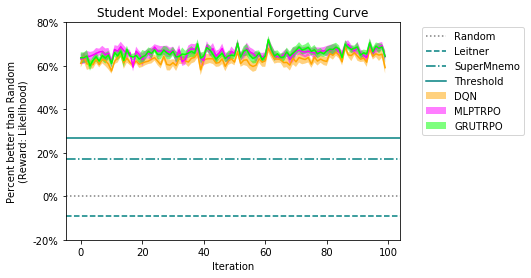

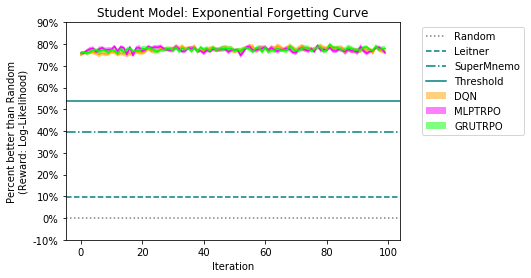

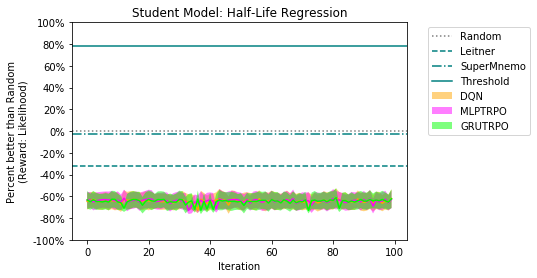

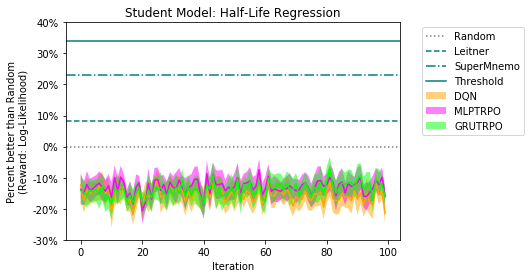

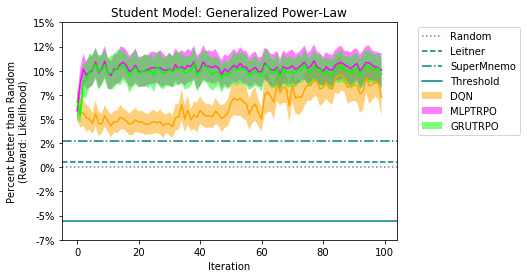

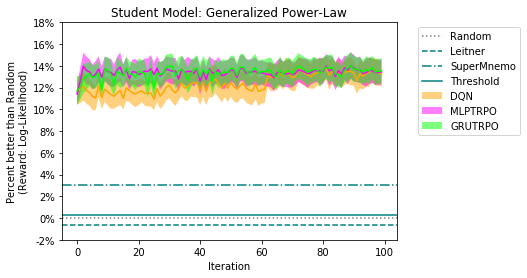

In [5]:
title_of_env_name = {
    "EFC": "Exponential Forgetting Curve",
    "HLR": "Half-Life Regression",
    "DASH": "Generalized Power-Law",
}

for h, env_name in enumerate(envs):
    for m, reward_func in enumerate(reward_funcs):
        k = h * len(reward_funcs) + m

        plt.xlabel("Iteration")
        plt.ylabel(
            "Percent better than Random\n(Reward: %s)"
            % reward_func.replace("_", "-")
            .replace("likelihood", "Likelihood")
            .replace("log", "Log")
        )
        plt.title("Student Model: %s" % title_of_env_name[env_name])

        colors = ["gray", "teal", "teal", "teal", "orange", "magenta", "lime"]
        styles = ["dotted", "dashed", "dashdot", "solid", "solid", "solid", "solid"]
        for i, tutor_name in enumerate(tutor_builders):
            if tutor_name in rl_tutors:
                x = range(R.shape[2])
                y1 = r_mins(R[k, i, :, :])
                y2 = r_maxs(R[k, i, :, :])
                plt.fill_between(
                    x,
                    y1,
                    y2,
                    where=y2 >= y1,
                    facecolor=colors[i],
                    interpolate=True,
                    alpha=0.5,
                    label=tutor_name,
                )
                plt.plot(r_means(R[k, i, :, :]), color=colors[i])
            else:
                plt.axhline(
                    y=np.nanmean(R[k, i, :, :]),
                    color=colors[i],
                    linestyle=styles[i],
                    label=tutor_name,
                )

        plt.yticks(plt.yticks()[0], [str(int(x)) + r"%" for x in plt.yticks()[0]])

        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.savefig(
            os.path.join(data_dir, "%s-%s.pdf" % (env_name, reward_func)),
            bbox_inches="tight",
        )
        plt.show()